# Evaluation
In order to experiment with new models, we first need a way to evaluate the results we achieved.

In [20]:
import pandas as pd


# We're using a document retriever class, to make it easier to perform the evaluator code on different models
class DocumentRetriever:
    all_docs = pd.read_csv("data/all_docs.csv")
    all_queries = pd.read_csv("data/dev_queries.csv")

    @staticmethod
    def get_value_by_id_from_df(id, id_column, value_column, df):
        value = df[df[id_column] == id][value_column].iat[0]
        return value

    @staticmethod
    def query_nr_to_text(query_nr):
        return DocumentRetriever.get_value_by_id_from_df(query_nr, 'Query_number', 'Query',
                                                         DocumentRetriever.all_queries)

    @staticmethod
    def doc_nr_to_text(doc_number):
        return DocumentRetriever.get_value_by_id_from_df(doc_number, 'doc_number', 'doc_text',
                                                         DocumentRetriever.all_docs)

    def __init__(self):
        pass

    def retrieve_documents(self, query_number, n):
        # Return the n best recommendations (ordered by decreasing relevance) for given query
        raise Exception("Function not implemented in subclass")

In [21]:
class LuceneRetriever(DocumentRetriever):
    lucene_raw_retrievals = pd.read_csv("data/raw_dev_Lucene_retrievals.csv")

    def __init__(self):
        super().__init__()

    def retrieve_documents(self, query_number, n):
        relevant_docs = self.lucene_raw_retrievals[self.lucene_raw_retrievals['Query_number'] == query_number]
        top_n = relevant_docs.head(n)
        return top_n['doc_number'].to_list()


luceneRetriever = LuceneRetriever()
results = luceneRetriever.retrieve_documents(1089071, 10)
results

[476602, 432658, 429474, 346632, 122086, 362869, 60461, 417115, 29215, 467667]

In [22]:
class GroundTruthRetriever(DocumentRetriever):
    ground_truth = pd.read_csv("data/dev_data.csv")

    def __init__(self):
        super().__init__()

    def retrieve_documents(self, query_number, n):
        #assert n is None # The truth has no limits, it just retrieves all relevant documents -> nevermind, the ground_truth is also ranked, so I can perfectly get a top-k
        query_results = self.ground_truth[self.ground_truth['Query_number'] == query_number]
        relevant_docs = query_results[query_results['label'] == 1]
        top_n = relevant_docs.head(n)
        return top_n['doc_number'].to_list()

In [23]:
from tqdm.notebook import tqdm


class ModelRater:
    ground_truth_retriever = GroundTruthRetriever()
    probe_data = pd.read_csv("data/dev_queries.csv")

    def __init__(self):
        pass

    def single_query_recall_precission(self, query_nr, n, retriever):
        query_results = set(retriever.retrieve_documents(query_nr, n))
        ground_truth = set(self.ground_truth_retriever.retrieve_documents(query_nr, n))

        # Some of this code is based on https://stackoverflow.com/questions/55952408/how-to-calculate-precision-and-recall-of-2-lists-in-python
        intersect_length = len(query_results.intersection(ground_truth))
        precision = intersect_length / len(query_results)
        recall = intersect_length / len(ground_truth)

        # print(f"R({recall}), P({precision})")

        return recall, precision

    def get_rating(self, retriever: DocumentRetriever, n=10) -> (float, float):
        # returns the recall, precision

        precision_sum = 0
        recall_sum = 0
        query_count = 0
        # For every query in probe data, determine the results
        for counter, query in tqdm(self.probe_data.iterrows(), total=self.probe_data.shape[0]):
            query_nr = query['Query_number']

            recall, precision = self.single_query_recall_precission(query_nr, n, retriever)

            precision_sum += precision
            recall_sum += recall
            query_count += 1

        avg_precision = precision_sum / query_count
        avg_recall = recall_sum / query_count

        print(f"Recall@{n}: {avg_recall}, Precision@{n}: {avg_precision}")

        return avg_recall, avg_precision


rater = ModelRater()

In [5]:
# Just for testing, this should return 1, 1
rater.get_rating(ModelRater.ground_truth_retriever)

  0%|          | 0/644 [00:00<?, ?it/s]

Recall@10: 1.0, Precision@10: 1.0


(1.0, 1.0)

In [6]:
recall, precision = rater.get_rating(luceneRetriever)

  0%|          | 0/644 [00:00<?, ?it/s]

Recall@10: 0.49958099181701693, Precision@10: 0.49642857142857183


The problem in this comment has been fixed (and so it's outdated). You'll read more about the fix somewhere below, in the section "Rater changes".

Copy of the output on which the comment was based:
```
Recall: 0.32744769762105247, Precision: 1.0
```
It's strange that the precision is always exactly 1.0. This is probably because the ground truth results (dev_data.csv) is based on the lucene retrievals (raw_dev_Lucene_retrievals.csv).

## BM25 retrieval
Another lexical search, which was mentioned in the SBERT-Documentation. Note that some of the methods here are partially copied from that documentation.

We already defined a help function in the DocumentRetriever class to get the query given the query_nr.

In [7]:
DocumentRetriever.query_nr_to_text(1099178)

'how does sperm develop'

In [8]:
# We also compare the results to lexical search (keyword search). Here, we use
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
import numpy as np


class Bm25Retriever(DocumentRetriever):
    def __init__(self):
        super().__init__()

        self.reverse_index = []
        self.tokenized_corpus = []
        for count, row in tqdm(DocumentRetriever.all_docs.iterrows(), total=DocumentRetriever.all_docs.shape[0]):
            # Work with a smaller dataset when debugging
            # if len(self.reverse_index) == 1000:
            #     break
            passage = str(row['doc_text'])
            doc_nr = row['doc_number']
            self.tokenized_corpus.append(self.bm25_tokenizer(passage))
            self.reverse_index.append(doc_nr)

        self.bm25 = BM25Okapi(self.tokenized_corpus)

    # We lower case our text and remove stop-words from indexing
    @staticmethod
    def bm25_tokenizer(text):
        tokenized_doc = []
        for token in text.lower().split():
            token = token.strip(string.punctuation)

            if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
                tokenized_doc.append(token)
        return tokenized_doc

    def search(self, query_text, n):
        # This code is based on the code from sbert-doc.ipynb
        bm25_scores = self.bm25.get_scores(self.bm25_tokenizer(query_text))
        top_n = np.argpartition(bm25_scores, -n)[-n:]
        bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
        bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

        results = []
        for hit in bm25_hits:
            results.append(self.reverse_index[hit['corpus_id']])
        return results

    def retrieve_documents(self, query_number, n):
        return self.search(self.query_nr_to_text(query_number), n)


bm25Retriever = Bm25Retriever()
recall, precision = rater.get_rating(bm25Retriever)

## MsMarco
See what's the precision on the pretrained MsMarco bi-encoder and cross-encoder. Some of the methods are based on code from the `sbert-doc.ipynb` notebook.

In [9]:
class ReRankRetriever(DocumentRetriever):
    def __init__(self, top_k=50):
        """
        :param top_k: Number of variables to get with the first function
        """
        super().__init__()
        self.top_k = top_k  #Number of passages we want to select before reranking

    def select_candidates(self, query, query_nr=None):
        # Typically done by e.g. a bi-encoder
        raise Exception("Not implemented")

    def rerank_candidates(self, candidates, query):
        # Candidates is the output of the select_candidates function
        # Typically done by e.g. a cross-encoder
        raise Exception("Not implemented")

    def retrieve_documents(self, query_nr, n):
        query = self.query_nr_to_text(query_nr)

        # Find potentially relevant passages
        hits = self.select_candidates(query, query_nr=query_nr)

        # Re-rank those matches
        ranked = self.rerank_candidates(hits, query)

        return ranked[0:n]

In [10]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
from tqdm import tqdm


class BiCrossRetriever(ReRankRetriever):
    def __init__(self, bi_encoder_name='msmarco-bert-base-dot-v5',
                 cross_encoder_name='cross-encoder/ms-marco-TinyBERT-L-2-v2'):
        super().__init__()
        print("Super inited")

        if not torch.cuda.is_available():
            print("Warning: No GPU found. Please add GPU to your notebook")

        #We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
        self.bi_encoder = SentenceTransformer(bi_encoder_name)
        self.bi_encoder.max_seq_length = 256  #Truncate long passages to 256 tokens

        #The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
        self.cross_encoder = CrossEncoder(cross_encoder_name)

        self.passages = []
        self.reverse_indices = []
        for index, row in tqdm(self.all_docs.iterrows(), total=self.all_docs.shape[0]):
            # if len(self.passages) > 50:
            #     # Use a very small subset when debugging
            #     break
            data = row['doc_text']
            first_words = " ".join(str(data).split()[:500])  # Only take the first 500 words
            self.passages.append(first_words)
            self.reverse_indices.append(row['doc_number'])

        print("Passages:", len(self.passages))

        # We encode all passages into our vector space.
        self.corpus_embeddings = self.bi_encoder.encode(self.passages, convert_to_tensor=True, show_progress_bar=True)

    def select_candidates(self, query, query_nr=None):
        # Get the bi-encoder hits
        question_embedding = self.bi_encoder.encode(query, convert_to_tensor=True)
        question_embedding = question_embedding.cuda()
        hits = util.semantic_search(question_embedding, self.corpus_embeddings, top_k=self.top_k)
        hits = hits[0]  # Get the hits for the first query
        return hits

    def rerank_candidates(self, candidates, query, n=None):
        # Rank with cross-encoder
        cross_inp = [[query, self.passages[hit['corpus_id']]] for hit in candidates]
        cross_scores = self.cross_encoder.predict(cross_inp)

        # Sort results by the cross-encoder scores
        for idx in range(len(cross_scores)):
            candidates[idx]['cross-score'] = cross_scores[idx]
        hits = sorted(candidates, key=lambda x: x['cross-score'], reverse=True)

        if n is not None:
            hits = hits[0:n]

        results = []
        for hit in hits:
            results.append(self.reverse_indices[hit['corpus_id']])

        return results

biCrossRetriever = BiCrossRetriever()
recall, precision = rater.get_rating(biCrossRetriever)

In [31]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import torch
from tqdm import tqdm


class LuceneCrossRetriever(ReRankRetriever):
    # Firsts selects top-k hits using lucene, then reranks them using a cross-encoder
    lucene_retriever = LuceneRetriever()

    def __init__(self, cross_encoder_name='cross-encoder/ms-marco-TinyBERT-L-2-v2', cross_encoder=None):
        super().__init__()  #Note: If this retriever is too slow for you, you can lower the top-k value here
        if cross_encoder is not None:
            self.cross_encoder = cross_encoder
        else:
            self.cross_encoder = CrossEncoder(cross_encoder_name)

    def select_candidates(self, query, query_nr=None):
        assert query_nr is not None
        lucene_results = self.lucene_retriever.retrieve_documents(query_nr, n=self.top_k)
        return list(map(lambda x: {'doc_nr': x}, lucene_results))

    def rerank_candidates(self, candidates, query, n=None):
        # Rank with cross-encoder
        cross_inp = [[query, DocumentRetriever.doc_nr_to_text(hit['doc_nr'])] for hit in candidates]
        cross_scores = self.cross_encoder.predict(cross_inp)

        # Sort results by the cross-encoder scores
        for idx in range(len(cross_scores)):
            candidates[idx]['cross-score'] = cross_scores[idx]
        hits = sorted(candidates, key=lambda x: x['cross-score'], reverse=True)

        if n is not None:
            hits = hits[0:n]

        results = []
        for hit in hits:
            results.append(hit['doc_nr'])

        return results

luceneCrossRetriever = LuceneCrossRetriever()
recall, precision = rater.get_rating(luceneCrossRetriever)


## Rater changes
This initially gave the same results as the LuceneRetriever, which is probably the best possible result for recall@10 and precission@10, because the ground truth was probably based on Lucene. This means that I'll have to change the rater.
First thing we might consider, is lowering the number of elements that get retrieved when creating the recall and the precission (currently n=10).

In [12]:
rater.get_rating(luceneRetriever, 1)
rater.get_rating(luceneRetriever, 3)
rater.get_rating(luceneRetriever, 5)
rater.get_rating(luceneRetriever, 10)
rater.get_rating(luceneRetriever, 50)

100%|██████████| 644/644 [00:00<00:00, 1166.67it/s]


Recall@1: 0.44875776397515527, Precision@1: 0.44875776397515527


100%|██████████| 644/644 [00:00<00:00, 1149.93it/s]


Recall@3: 0.4860248447204972, Precision@3: 0.4860248447204972


100%|██████████| 644/644 [00:00<00:00, 1154.05it/s]


Recall@5: 0.4885093167701864, Precision@5: 0.4885093167701864


100%|██████████| 644/644 [00:00<00:00, 1137.87it/s]


Recall@10: 0.49958099181701693, Precision@10: 0.49642857142857183


100%|██████████| 644/644 [00:00<00:00, 1017.38it/s]

Recall@50: 1.0, Precision@50: 0.5026468846546215


(1.0, 0.5026468846546215)

Copy of the original output (since this might get lost when reexecuting):
```
100%|██████████| 644/644 [00:00<00:00, 917.35it/s]
Recall: 0.03274476976210539, Precision: 1.0
100%|██████████| 644/644 [00:00<00:00, 993.27it/s]
Recall: 0.0982343092863159, Precision: 1.0
100%|██████████| 644/644 [00:00<00:00, 1002.92it/s]
Recall: 0.16372384881052623, Precision: 1.0
100%|██████████| 644/644 [00:00<00:00, 877.29it/s]
Recall: 0.32744769762105247, Precision: 1.0
100%|██████████| 644/644 [00:00<00:00, 914.63it/s]
Recall: 1.0, Precision: 0.9993899733806567
```
The precision remains kind off the same (only whith n=50 it's not 1.0, but that's probably because the ground truth doesn't have 50 matches for everything).
The recall gets higher, which makes sense, since more of the results get retrieved.
This is still not what we want, since we can't compare our models this way.

### Relevant only
I'm just stupied, I forgot to only use the relevant documents :facepalm: The code above has been updated.

In [13]:
rater.get_rating(luceneRetriever, 1)
rater.get_rating(luceneRetriever, 3)
rater.get_rating(luceneRetriever, 5)
rater.get_rating(luceneRetriever, 10)
rater.get_rating(luceneRetriever, 50)

100%|██████████| 644/644 [00:00<00:00, 1120.00it/s]


Recall@1: 0.44875776397515527, Precision@1: 0.44875776397515527


100%|██████████| 644/644 [00:00<00:00, 1136.61it/s]


Recall@3: 0.4860248447204972, Precision@3: 0.4860248447204972


100%|██████████| 644/644 [00:00<00:00, 1166.59it/s]


Recall@5: 0.4885093167701864, Precision@5: 0.4885093167701864


100%|██████████| 644/644 [00:00<00:00, 1158.14it/s]


Recall@10: 0.49958099181701693, Precision@10: 0.49642857142857183


100%|██████████| 644/644 [00:00<00:00, 1156.13it/s]

Recall@50: 1.0, Precision@50: 0.5026468846546215


(1.0, 0.5026468846546215)

### Ground truth top-k only
Appearently, the results in the ground truth are also ranked based on relvance, I can also here just use the top-k instead of always comparing with all relevant documents.

In [24]:
rater.get_rating(luceneRetriever, 1)
rater.get_rating(luceneRetriever, 3)
rater.get_rating(luceneRetriever, 5)
rater.get_rating(luceneRetriever, 10)
rater.get_rating(luceneRetriever, 50)

  0%|          | 0/644 [00:00<?, ?it/s]

Recall@1: 0.44875776397515527, Precision@1: 0.44875776397515527


  0%|          | 0/644 [00:00<?, ?it/s]

Recall@3: 0.4860248447204972, Precision@3: 0.4860248447204972


  0%|          | 0/644 [00:00<?, ?it/s]

Recall@5: 0.4885093167701864, Precision@5: 0.4885093167701864


  0%|          | 0/644 [00:00<?, ?it/s]

Recall@10: 0.49958099181701693, Precision@10: 0.49642857142857183


  0%|          | 0/644 [00:00<?, ?it/s]

Recall@50: 1.0, Precision@50: 0.5026468846546215


(1.0, 0.5026468846546215)

# Intermediate Results
Here is an overview of the results we got so far:

| Name                       | Recall@10 | Precission@10 |
|----------------------------|-----------|---------------|
| GroundTruthRetriever       | 1.00000   | 1.00000       |
| LuceneRetriever            | 0.49958   | 0.49642       |
| Bm25Retriever              | 0.43229   | 0.56536       |
| BiCrossRetriever (MsMarco) | 0.25137   | 0.30258       |
| LuceneCrossRetriever       | 0.43721   | 0.43416       |

The LuceneRetriever is currently still having the best recall and the best precission is for the Bm25Retriever, which also isn't a neural retrieval model (besides the GroundTruthRetriever of course, which is perfect).
Strangely, the BiCrossRetriever is the worst of them all, so I'll try to improve the LuceneCrossRetriever.

# CrossEncoders
The LuceneRetriever is currently working the best, so try this one with some different CrossEncoders.
I tested some pretrained models listed in the [documentation](https://www.sbert.net/docs/pretrained_cross-encoders.html).

In [9]:
# For some reason this also doesn't solve the cuda out of memory error
# torch.cuda.empty_cache()

# The one we tried earlier
print('ms-marco-TinyBERT-L-2-v2')
rater.get_rating(LuceneCrossRetriever('cross-encoder/ms-marco-TinyBERT-L-2-v2'))

# A more powerfull version of the Ms-Marco (but takes more time)
print('ms-marco-MiniLM-L-12-v2')
rater.get_rating(LuceneCrossRetriever('cross-encoder/ms-marco-MiniLM-L-12-v2'))

# SQuAD - Trained for answering questions
print('qnli-electra-base')
rater.get_rating(LuceneCrossRetriever('cross-encoder/qnli-electra-base'))

# STSbenchmark
print('stsb-TinyBERT-L-4')
rater.get_rating(LuceneCrossRetriever('cross-encoder/stsb-TinyBERT-L-4'))
rater.get_rating(LuceneCrossRetriever('cross-encoder/stsb-roberta-large'))

ms-marco-TinyBERT-L-2-v2


  0%|          | 0/644 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 2.73 GiB already allocated; 0 bytes free; 2.75 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Cuda ran out of memory with the last one, so I copy pasted the output here and reran the last rater:
```
ms-marco-TinyBERT-L-2-v2
100%|██████████| 644/644 [01:35<00:00,  6.72it/s]
Recall@10: 0.4372165532879821, Precision@10: 0.4341614906832301
ms-marco-MiniLM-L-12-v2'
100%|██████████| 644/644 [11:33<00:00,  1.08s/it]
Recall@10: 0.4507622251799272, Precision@10: 0.4478260869565217
qnli-electra-base
100%|██████████| 644/644 [34:20<00:00,  3.20s/it]
Recall@10: 0.36328564034309485, Precision@10: 0.3605590062111812
stsb-TinyBERT-L-4
100%|██████████| 644/644 [03:28<00:00,  3.09it/s]
Recall@10: 0.33324028886917134, Precision@10: 0.33090062111801294
  0%|          | 1/644 [00:06<1:11:40,  6.69s/it]
 ---------------------------------------------------------------------------

RuntimeError                              Traceback (most recent call last)
 ```
The last one keeps giving an out of memory error, but since the other STSB Cross-Encoder didn't give that good results, I won't spend more time on trying to fix it (since I already wasted quite some time trying to fix this).

## Overview LuceneCrossRetriever

| Name                                    | Recall@10 | Precission@10 | Time       |
|-----------------------------------------|-----------|---------------|------------|
| LuceneRetriever                         | 0.49958   | 0.49642       | 431.44it/s |
| BiCrossRetriever (MsMarco)              | 0.24137   | 0.30258       | 1.62it/s   |
| LuceneCrossRetriever (MsMarco-TinyBERT) | 0.43721   | 0.43416       | 6.72it/s   |
| LuceneCrossRetriever (MsMarco-MiniLM)   | 0.45076   | 0.44782       | 1.08s/it   |
| LuceneCrossRetriever (QNLI)             | 0.36328   | 0.36055       | 3.20s/it   |
| LuceneCrossRetriever (STSB-TinyBERT)    | 0.33324   | 0.33090       | 3.09it/s   |
| LuceneCrossRetriever (STSB-Roberta)     | ERROR     | ERROR         | ERROR      |

The original LuceneRetriver remains the best one. Based on those results, I select the MsMarco-TinyBERT pretrained model to train further.
The MsMarco-MiniLM is slightly better, but the 6x speed difference is not worth it.

## Training
I currently only used pretrained models, without training themselves further.
Let's try the same training as in `experiments.ipynb`.
Since our final task is to re-rank the (small number of) results in the test dataset (and because the LuceneRetriever scored better than the BiCrossRetriever), it wouldn't be really usefull to train a bi-encoder, but we can immediately try to train a cross-encoder.

In [35]:
# This was some code to try to get my GPU to work (which is quite important for faster training)
# updating my cuda driver, installing pytorch accoording to their site https://pytorch.org/ and restarting my computer solved this after a lot of struggling

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2" # Since GPU 0 won't work on my laptop
# import torch
# available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
# available_gpus

In [43]:
all_training = pd.read_csv("data/training_data.csv")

# Use 80% of the training dataset as training data, the other 20% is validation data
# We can't use the dev_data.csv for our evaluator, since this dataset will already be used for testing
# src: https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
train_data = all_training.sample(frac=0.8, random_state=0)  #random state is a seed value
dev_data = all_training.drop(train_data.index)

In [20]:
from sentence_transformers import InputExample


def get_sample_list(df):
    samples = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        query = str(row['Query'])
        doc_text = str(row['doc_text'])

        label = float(row['label'])

        inp_example = InputExample(texts=[query, doc_text], label=label)

        samples.append(inp_example)
    return samples


train_samples = get_sample_list(train_data)
dev_samples = get_sample_list(dev_data)

100%|██████████| 28000/28000 [00:01<00:00, 25201.77it/s]


In [44]:
import torch
from torch.utils.data import DataLoader
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os

from sentence_transformers import InputExample
import pandas as pd

# Code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])


def train_model(train_samples, dev_samples, model_name, train_batch_size, num_epochs, model_save_path):
    # Load a pre-trained sentence transformer model
    model = SentenceTransformer(model_name)

    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

    train_loss = losses.CosineSimilarityLoss(model=model)

    evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='ms-marco')

    # Configure the training. We skip evaluation in this example
    warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)  #10% of train data for warm-up
    logging.info("Warmup-steps: {}".format(warmup_steps))

    # Train the model
    model.fit(train_objectives=[(train_dataloader, train_loss)],
              evaluator=evaluator,
              epochs=num_epochs,
              warmup_steps=warmup_steps,
              output_path=model_save_path)

2022-01-02 17:06:26 - Load pretrained SentenceTransformer: cross-encoder/ms-marco-TinyBERT-L-2-v2


Some weights of the model checkpoint at C:\Users\arnod/.cache\torch\sentence_transformers\cross-encoder_ms-marco-TinyBERT-L-2-v2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2022-01-02 17:06:30 - No sentence-transformers model found with name C:\Users\arnod/.cache\torch\sentence_transformers\cross-encoder_ms-marco-TinyBERT-L-2-v2. Creating a new one with MEAN pooling.
2022-01-02 17:06:30 - Use pytorch device: cuda
2022-01-02 17:06:30 - Read the train dataset
2022-01-02 17:06:30 - Read dev dataset
2022-01-02 17:06:30 - Warmup-steps: 2800


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

2022-01-02 17:28:31 - EmbeddingSimilarityEvaluator: Evaluating the model on ms-marco dataset after epoch 0:
2022-01-02 17:32:33 - Cosine-Similarity :	Pearson: 0.2840	Spearman: 0.2783
2022-01-02 17:32:33 - Manhattan-Distance:	Pearson: 0.2704	Spearman: 0.2648
2022-01-02 17:32:33 - Euclidean-Distance:	Pearson: 0.2760	Spearman: 0.2707
2022-01-02 17:32:33 - Dot-Product-Similarity:	Pearson: 0.2749	Spearman: 0.2686
2022-01-02 17:32:33 - Save model to output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4


Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

2022-01-02 17:53:57 - EmbeddingSimilarityEvaluator: Evaluating the model on ms-marco dataset after epoch 1:
2022-01-02 17:59:55 - Cosine-Similarity :	Pearson: 0.3307	Spearman: 0.3259
2022-01-02 17:59:55 - Manhattan-Distance:	Pearson: 0.3180	Spearman: 0.3128
2022-01-02 17:59:55 - Euclidean-Distance:	Pearson: 0.3233	Spearman: 0.3174
2022-01-02 17:59:55 - Dot-Product-Similarity:	Pearson: 0.3143	Spearman: 0.3082
2022-01-02 17:59:55 - Save model to output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4


Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

2022-01-02 18:19:48 - EmbeddingSimilarityEvaluator: Evaluating the model on ms-marco dataset after epoch 2:
2022-01-02 18:23:05 - Cosine-Similarity :	Pearson: 0.3451	Spearman: 0.3415
2022-01-02 18:23:05 - Manhattan-Distance:	Pearson: 0.3336	Spearman: 0.3279
2022-01-02 18:23:05 - Euclidean-Distance:	Pearson: 0.3384	Spearman: 0.3320
2022-01-02 18:23:05 - Dot-Product-Similarity:	Pearson: 0.3342	Spearman: 0.3291
2022-01-02 18:23:05 - Save model to output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4


Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

2022-01-02 18:42:08 - EmbeddingSimilarityEvaluator: Evaluating the model on ms-marco dataset after epoch 3:
2022-01-02 18:45:37 - Cosine-Similarity :	Pearson: 0.3496	Spearman: 0.3469
2022-01-02 18:45:37 - Manhattan-Distance:	Pearson: 0.3398	Spearman: 0.3344
2022-01-02 18:45:37 - Euclidean-Distance:	Pearson: 0.3438	Spearman: 0.3379
2022-01-02 18:45:37 - Dot-Product-Similarity:	Pearson: 0.3404	Spearman: 0.3361
2022-01-02 18:45:37 - Save model to output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4


TypeError: __init__() takes 1 positional argument but 2 were given

In [14]:
model_name = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
train_batch_size = 16
num_epochs = 4
model_save_path = f'output/training-{model_name}-b{train_batch_size}e{num_epochs}'

train_model(train_samples, dev_samples, model_name, train_batch_size, num_epochs, model_save_path)

# Training done, now evaluate the model
print("Evaluating again, since error after training")
luceneCrossRetriever = LuceneCrossRetriever(model_save_path)
print("Calculating score")
recall, precision = rater.get_rating(luceneCrossRetriever)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating again, since error after training
Calculating score


100%|██████████| 644/644 [01:18<00:00,  8.16it/s]

Recall@10: 0.2834966232869955, Precision@10: 0.28121118012422314


Here is an overview:

| Name                         | Recall@10 | Precission@10 |
|------------------------------|-----------|---------------|
| LuceneRetriever              | 0.49958   | 0.49642       |
| BiCrossRetriever (MsMarco)   | 0.25137   | 0.30258       |
| LuceneCrossRetriever         | 0.43721   | 0.43416       |
| Trained LuceneCrossRetriever Attempt 1 | 0.28349   | 0.28121       |

## Better attempt?
The training makes it even worse (which is very strange). This is probably because I just used a standard losses function instead of searching one for our specific use case.
As mentioned multiple times in the documentation, there is no One-Size-Fits-All loss-function, but the loss function I used was clearly one that wasn't inteded for a cross-encoder.
To find the right function, I took a look at the [losses documentation](https://www.sbert.net/docs/package_reference/losses.html), but here wasn't anything explicitly mentioned for training cross-encoder. However, there were some training examples on the [Cross-Encoders page](https://www.sbert.net/examples/training/cross-encoder/README.html).
By looking at [one of the examples](https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/cross-encoder/training_stsbenchmark.py), the main difference was the evaluator and they didn't provide any loss function, so let's also try to do that. I also used a SentenceTransformer as model instead of a CrossEncoder, so I made quite some mistakes that might declare the worse results.

In [23]:
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from torch.utils.data import DataLoader
import math

# For some reason, I can't reuse a sample list, so let's generate it again
train_samples = get_sample_list(train_data)
dev_samples = get_sample_list(dev_data)

model_name = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
train_batch_size = 16
num_epochs = 4
model_save_path = f'output/training-{model_name}-b{train_batch_size}e{num_epochs}'

model = CrossEncoder(model_name)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='ms-marco-attempt-2')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

# Training done, now evaluate the model
luceneCrossRetriever = LuceneCrossRetriever(model_save_path)
recall, precision = rater.get_rating(luceneCrossRetriever)

100%|██████████| 28000/28000 [00:01<00:00, 23608.08it/s]


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 644/644 [01:38<00:00,  6.56it/s]

Recall@10: 0.5427265108942125, Precision@10: 0.5392857142857139


Finally, the results are getting better than Lucene :-) (That smiley is my happy face once I saw those results)
We're now having a recall of 0.54272 and a Precision of 0.53928. Let's try some more epochs to see if things are improving that way.

There is also an entire `sentence_transformers.cross_encoder.evaluation` file.
When searching for the documentation of this file, I noticed that the documentation of the cross_encoder evaluators were listed on [another page in the documentation](https://www.sbert.net/docs/package_reference/cross_encoder.html).

On this documentation page, I found that there was a CERerankingEvaluator, which is exactly the evaluator we need.

We now try more epochs and use the CERerankingEvaluator to see the evolution.

In [26]:
from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator
from torch.utils.data import DataLoader
import math


def get_reranking_samples(df):
    samples = []
    previous_query = None
    positive = []
    negative = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        query = str(row['Query'])
        if query != previous_query and previous_query is not None:
            samples.append({'query': query, 'positive': positive[:], 'negative': negative[:]})
            positive = []
            negative = []
        doc_text = str(row['doc_text'])
        label = float(row['label'])
        if label == 1.0:
            positive.append(doc_text)
        else:
            negative.append(doc_text)
        previous_query = query
    return samples


train_samples = get_sample_list(train_data)
dev_samples = get_reranking_samples(dev_data)

model_name = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
train_batch_size = 16
num_epochs = 20
model_save_path = f'output/training-{model_name}-b{train_batch_size}e{num_epochs}-attempt3'

model = CrossEncoder(model_name, num_labels=1)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
evaluator = CERerankingEvaluator(dev_samples, name='ms-marco-attempt-3')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

# Training done, now evaluate the model
luceneCrossRetriever = LuceneCrossRetriever(model_save_path)
recall, precision = rater.get_rating(luceneCrossRetriever)

100%|██████████| 28000/28000 [00:01<00:00, 25827.72it/s]


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 644/644 [01:27<00:00,  7.35it/s]

Recall@10: 0.5391051710539284, Precision@10: 0.5357142857142855


More epochs doesn't seem to give better result, surprisingly, the results were even slightly worse.
We now used the evaluator, so we can take a look at how the quality evolves when we do more epochs.

<AxesSubplot:xlabel='epoch'>

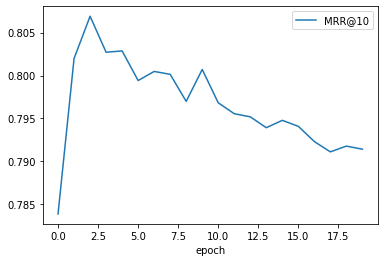

In [27]:
# Load the CERerankingEvaluator data
df = pd.read_csv(f"{model_save_path}/CERerankingEvaluator_ms-marco-attempt-3_results.csv")
df.plot(x='epoch', y='MRR@10')

In the data we can see that it slightly gets worse when we do more epochs. The best results (on are dev data) are achieved after two epochs, so let's continue using that then.

In [28]:
model_name = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
train_batch_size = 16
num_epochs = 2
model_save_path = f'output/training-{model_name}-b{train_batch_size}e{num_epochs}-attempt4'

model = CrossEncoder(model_name, num_labels=1)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
evaluator = CERerankingEvaluator(dev_samples, name='ms-marco-attempt-3')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

# Training done, now evaluate the model
luceneCrossRetriever = LuceneCrossRetriever(model_save_path)
recall, precision = rater.get_rating(luceneCrossRetriever)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 644/644 [02:05<00:00,  5.13it/s]

Recall@10: 0.5333857093562061, Precision@10: 0.5301242236024845


Our model after 4 epochs still gave a slightly better result, so let's just use that one instead.

In [35]:
# I accidentally overwritten that model, so let's try generating it again

from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from torch.utils.data import DataLoader
import math

# For some reason, I can't reuse a sample list, so let's generate it again
train_samples = get_sample_list(train_data)
dev_samples = get_sample_list(dev_data)

model_name = 'cross-encoder/ms-marco-TinyBERT-L-2-v2'
train_batch_size = 16
num_epochs = 4
model_save_path = f'output/training-{model_name}-b{train_batch_size}e{num_epochs}'

model = CrossEncoder(model_name)
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='ms-marco-attempt-2')
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1)

model.fit(train_dataloader=train_dataloader,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

# Training done, now evaluate the model
luceneCrossRetriever = LuceneCrossRetriever(model_save_path)
recall, precision = rater.get_rating(luceneCrossRetriever)

100%|██████████| 28000/28000 [00:01<00:00, 19548.86it/s]


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

Iteration:   0%|          | 0/7000 [00:00<?, ?it/s]

100%|██████████| 644/644 [02:13<00:00,  4.81it/s]

Recall@10: 0.5427265108942125, Precision@10: 0.5392857142857139


## Truncate length
There are still a lot of hyperparameters that can be tuned, but I can keep on going endlessly if I do that.
Since we're not going to do all of them, let's take a look at the truncate length as last one.

In [36]:
model_name = 'output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4/'
model = CrossEncoder(model_name)
print(model.max_length)

None


Strangely, there is no max_length set for this model, meaning that it can just run with any input length. Let's try to set some different max_length values.

Evaluating length 16


100%|██████████| 644/644 [02:44<00:00,  3.91it/s]


Recall@10: 0.4056430543231791, Precision@10: 0.403260869565218
Evaluating length 32


100%|██████████| 644/644 [01:41<00:00,  6.32it/s]


Recall@10: 0.45131433007985844, Precision@10: 0.44875776397515543
Evaluating length 64


100%|██████████| 644/644 [01:42<00:00,  6.26it/s]


Recall@10: 0.47991595188800135, Precision@10: 0.47686335403726665
Evaluating length 128


100%|██████████| 644/644 [01:45<00:00,  6.09it/s]


Recall@10: 0.4861228186926945, Precision@10: 0.4829192546583851
Evaluating length 256


100%|██████████| 644/644 [02:01<00:00,  5.30it/s]


Recall@10: 0.5004492014196982, Precision@10: 0.49704968944099354
Evaluating length 512


100%|██████████| 644/644 [02:10<00:00,  4.93it/s]


Recall@10: 0.5427265108942125, Precision@10: 0.5392857142857139


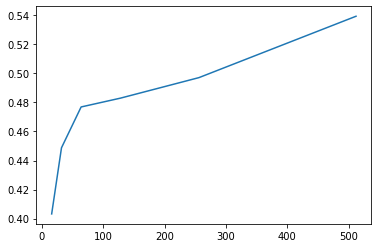

In [37]:
# Let's just evaluate based on the precision
lenght_scores = []  # Will contain tuples (max_length, score)


def evaluate_length(max_length):
    print(f"Evaluating length {max_length}")
    model = CrossEncoder(model_name, max_length=max_length)
    luceneCrossRetriever = LuceneCrossRetriever(cross_encoder=model)
    recall, precision = rater.get_rating(luceneCrossRetriever)
    return precision


for i in [16, 32, 64, 128, 256, 512]:  # 1024]:
    lenght_scores.append((i, evaluate_length(i)))

# Plot the given lengths
# src: https://stackoverflow.com/questions/18458734/how-do-i-plot-list-of-tuples-in-python
import matplotlib.pyplot as plt

x, y = zip(*lenght_scores)
plt.plot(x, y)

Length 1024 causes a runtime error, but for the other values it is clear that the higher the max_length, the better the results (as expected).
```
RuntimeError: The size of tensor a (1024) must match the size of tensor b (512) at non-singleton dimension 1
```

In [38]:
# Run the model again, without a model specified
model = CrossEncoder(model_name)
luceneCrossRetriever = LuceneCrossRetriever(cross_encoder=model)
recall, precision = rater.get_rating(luceneCrossRetriever)

100%|██████████| 644/644 [02:02<00:00,  5.26it/s]

Recall@10: 0.5427265108942125, Precision@10: 0.5392857142857139


No max length specified gives the same output as when max_length = 512, but as mentioned earlier print(model.max_length) gave None. Maybe it still gets truncated at this length without having the correct variable set, but I couldn't find anything about that in

## Relevance labeling
The ModelRater currently mainly focussed on the ranking of documents.
This is achieved by giving a score with a cross-encoder.
To determine whether a document is relevant, we have to find a threshold for given score.
To find ths threshold, first generate a score for all training parts and then try some different values and see how well it performs on the dev_data.

In [1]:
from sentence_transformers import CrossEncoder
import pandas as pd

model_name = 'output/training-cross-encoder/ms-marco-TinyBERT-L-2-v2-b16e4/'
model = CrossEncoder(model_name)
train_data = pd.read_csv("data/training_data.csv")

# Assign scores made by our crossencoder for every training element.
# The predict function also has a show_progress_bar option, so we can just predict them all at once (while still having an idea of how long it will take)

# Create the pairs for which to predict the score
query_text = train_data[['Query', 'doc_text']]
# There is somewhere a record that is a float instead of a string, so cast everything to a string
query_text['Query'] = query_text['Query'].astype(str)
query_text['doc_text'] = query_text['doc_text'].astype(str)
# df to list op tuples (src: https://www.kite.com/python/answers/how-to-convert-a-pandas-dataframe-into-a-list-of-tuples-in-python)
records = query_text.to_records(index=False)
sentences = list(records)

# Predict the scores
scores = model.predict(sentences, show_progress_bar=True)

train_data['our_score'] = scores  # If scores is a np array, append .tolist()
train_data.head()

C:\Users\arnod\AppData\Local\Temp/ipykernel_17500/3629609854.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_text['Query'] = query_text['Query'].astype(str)
C:\Users\arnod\AppData\Local\Temp/ipykernel_17500/3629609854.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_text['doc_text'] = query_text['doc_text'].astype(str)


Batches:   0%|          | 0/4375 [00:00<?, ?it/s]

,Query_number,Query,doc_text,doc_number,index,label,our_score
0,2,androgen receptor define,Video Writeups The Ultimate Guide to Sarms Las...,177589,37451,1,-0.689590
1,2,androgen receptor define,Category: SARMSSARMS Reviewed and Explained Dy...,193130,37452,1,-0.316287
2,2,androgen receptor define,The Hormones : Androgens Construction and Prod...,392384,37453,1,1.347050
3,2,androgen receptor define,"Theriogenology Volume 80, Issue 6, 1 October 2...",15195,37454,1,0.731395
4,2,androgen receptor define,SARMs: The Controversial Muscle Builders of 20...,269140,37455,1,-1.335425


Great, we now have our scores added to the dataframe, let's see what a good threshold would be.

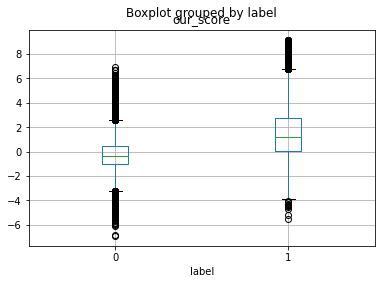

In [53]:
# Let's make some plots, because that always looks fancy
# And we can also use them to get a general idea of how our data is spread
# positive_labels = train_data[train_data['label'] == 1]
# negative_labels = train_data[train_data['label'] == 0]
#
# positive_label_scores = positive_labels[['our_score']]
# negative_label_scores = negative_labels[['our_score']]
#
# positive_label_scores.boxplot()
# negative_label_scores.boxplot()
#
# pos_neg_label_scores = pd.concat([positive_label_scores, negative_label_scores], keys=['positive', 'negative'])
#
# pos_neg_label_scores.boxplot()

# All code above isn't required anymore since I found the group_by option
boxplot = train_data.boxplot(column=['our_score'], by='label')

Given those boxplots, we can see that's its impossible to create a perfect threshold value, but we can try to maximize the correct predictions and minimize the wrong predictions by testing some different values. The best treshold will probably be somewhere between -0.5 and 1.5.

Note: to increase the recall, we should lower the treshold and to increase the precision, we should make the treshold higher.

Let's try some different possible threshold values. For this, we need an evaluation score, where we want to maximize the true positives and true negatives, and minimize the false positives and false negatives.
In this function, the higher the score, the better.

In [2]:
def get_threshold_score(threshold):
    filtered_relevant = train_data[train_data['our_score'] > threshold]
    filtered_irrelevant = train_data[train_data['our_score'] <= threshold]

    true_positives = filtered_relevant[filtered_relevant['label'] == 1]
    false_positives = filtered_relevant[filtered_relevant['label'] == 0]
    true_negatives = filtered_irrelevant[filtered_irrelevant['label'] == 0]
    false_negatives = filtered_irrelevant[filtered_irrelevant['label'] == 1]

    total_right = true_positives.count()['label'] + true_negatives.count()['label']
    total_wrong = false_positives.count()['label'] + false_negatives.count()['label']

    # Higher score is better
    score = total_right - total_wrong
    return score, total_right, total_wrong


get_threshold_score(0.5)

(55848, 97924, 42076)

In [4]:
import numpy as np  # Default python range doesn't support float steps
from tqdm import tqdm

# Test some possible threshold values
max_score = -float("inf")
best_threshold = 0

scores = []
rights = []
wrongs = []
thresholds = np.arange(-0.5, 1.5, 0.1)
for threshold in tqdm(thresholds, total=thresholds.size):
    score, right, wrong = get_threshold_score(threshold)
    scores.append(score)
    rights.append(right)
    wrongs.append(wrong)

    if score > max_score:
        print(f"New max with threshold {threshold}: {score}")
        max_score = score
        best_threshold = threshold

 20%|██        | 4/20 [00:00<00:01, 14.77it/s]

New max with threshold -0.5: 43834
New max with threshold -0.4: 46244
New max with threshold -0.30000000000000004: 48624
New max with threshold -0.20000000000000007: 50816


 40%|████      | 8/20 [00:00<00:00, 15.09it/s]

New max with threshold -0.10000000000000009: 52482
New max with threshold -1.1102230246251565e-16: 53628
New max with threshold 0.09999999999999987: 54730
New max with threshold 0.19999999999999984: 55212


 60%|██████    | 12/20 [00:00<00:00, 15.20it/s]

New max with threshold 0.2999999999999998: 55748
New max with threshold 0.3999999999999998: 55968


100%|██████████| 20/20 [00:01<00:00, 15.24it/s]


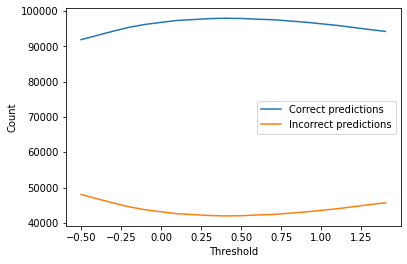

In [6]:
import matplotlib.pyplot as plt
# Make the plots
# src: https://howtothink.readthedocs.io/en/latest/PvL_H.html
plt.plot(thresholds, rights, label='Correct predictions')
plt.plot(thresholds, wrongs, label='Incorrect predictions')
plt.xlabel("Threshold")
plt.ylabel("Count")
plt.legend()
plt.show()

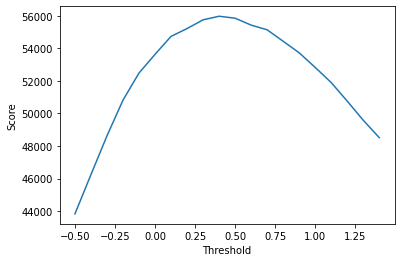

In [7]:
plt.plot(thresholds, scores)
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

Based on this, we'll use a cross-encoder score of 0.4 as threshold for a document to be relevant.

With this threshold, I can also generate a recall and precission for predicting labels (since I up to now only got one for recommending documents). However, the raw_dev_Lucene_retrievals.csv didn't contain a score or a label, so I can't use this as baseline to compare this recall and precission with it. The training set also only contains documents that we're retrieved, so only positives (false and true) and not negatives, so this also can't be used to get a baseline recall (but precision can be calculated with this).

In [17]:
# We determined the threshold using the train_data, so use another dataset to evaluate it
dev_data = pd.read_csv('data/dev_data.csv')

query_text = dev_data[['Query', 'doc_text']]
query_text['Query'] = query_text['Query'].astype(str)
query_text['doc_text'] = query_text['doc_text'].astype(str)

records = query_text.to_records(index=False)
sentences = list(records)

scores = model.predict(sentences, show_progress_bar=True)

dev_data['our_score'] = scores  # If scores is a np array, append .tolist()


C:\Users\arnod\AppData\Local\Temp/ipykernel_17500/3427433875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_text['Query'] = query_text['Query'].astype(str)
C:\Users\arnod\AppData\Local\Temp/ipykernel_17500/3427433875.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_text['doc_text'] = query_text['doc_text'].astype(str)


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [18]:
threshold = 0.4

filtered_relevant = dev_data[dev_data['our_score'] > threshold]
filtered_irrelevant = dev_data[dev_data['our_score'] <= threshold]

true_positives = filtered_relevant[filtered_relevant['label'] == 1].count()['label']
false_positives = filtered_relevant[filtered_relevant['label'] == 0].count()['label']
true_negatives = filtered_irrelevant[filtered_irrelevant['label'] == 0].count()['label']
false_negatives = filtered_irrelevant[filtered_irrelevant['label'] == 1].count()['label']

recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)

recall, precision

(0.5963632730542512, 0.6802279202279202)

Calculate the baseline precision for Lucene based on the training_data.csv

In [19]:
training_data = pd.read_csv('data/training_data.csv')

true_positives = training_data[training_data['label'] == 1].count()['label']
false_positives = training_data[training_data['label'] == 0].count()['label']

precision = true_positives / (true_positives + false_positives)

precision

0.4972142857142857

## Test dataset
Enough experiments, time to rate and rank the test dataset.

In [15]:
test_data = pd.read_csv("data/test_data.csv")

query_text = test_data[['Query', 'doc_text']]  # 5 for testing purposes

records = query_text.to_records(index=False)
sentences = list(records)

# Predict the scores
scores = model.predict(sentences, show_progress_bar=True)

test_data['relevance_score'] = scores

# Set the labels
# src: https://stackoverflow.com/questions/49161120/pandas-python-set-value-of-one-column-based-on-value-in-another-column
threshold = 0.4
test_data['label'] = np.where(test_data.relevance_score > threshold, 1, 0)

sorted = test_data.sort_values(by=["Query_number", "relevance_score"], ascending=[True, False])

sorted.to_csv('neural_model_rank.csv', index=False)

Batches:   0%|          | 0/57 [00:00<?, ?it/s]